In [20]:
import os
import itertools
import collections

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Setup functions

In [2]:
def load_dataframes(topdir):
    infiles = dict()
    for fname in os.listdir(topdir):
        if not os.path.isfile(os.path.join(topdir, fname)):
            continue

        hostname = fname.split('.')[0]
        infiles[hostname] = os.path.join(topdir, fname)

    dfs = dict()
    for key, val in infiles.items():
        df = pd.read_csv(val, sep='\t', header=0, parse_dates=['time'])
        df['load_estimate'] = df['loadavg'] * df['pcpu_fraction']
        df['lab'] = df['user'].apply(lambda x: USER_TO_LAB[x] if x in USER_TO_LAB else 'Other')
        dfs[key] = df
        
    return dfs

In [3]:
def get_linestyles(all_members):
    shapes = ["--", "-.", ":"]
    shapes_nodash = ["-"]
    # shapes = [
    #     (0, (1, 10)),
    #     (0, (1, 1)),
    #     (0, (10, 3)),
    #     (0, (5, 10)),
    #     (0, (3, 5, 1, 5)),
    #     (0, (3, 1, 1, 1)),
    # ]
    
    gapcolors = [None, 'black', 'gray']
    gapcolors_nodash = [None]
    
    n_color = int(np.ceil(len(all_members) / (1 + len(shapes) * len(gapcolors))))
    colors = mpl.colormaps['hsv'](np.linspace(0, 0.8, n_color))
    # colors = mpl.color_sequences['tab20'][:n_color]
    colors = [tuple(x) for x in colors]
    
    cycler = itertools.cycle(
        sorted(
            list(itertools.product(colors, shapes, gapcolors))
            + list(itertools.product(colors, shapes_nodash, gapcolors_nodash)),
            key=(lambda x: colors.index(x[0])),
        )
    )
    styles = dict()
    for member, styleitem in zip(all_members, cycler):
        styles[member] = {'linestyle': styleitem[1], 'color': styleitem[0], 'gapcolor': styleitem[2]}
    
    return styles


def get_linestyles_brief(all_members):
    shapes = ["-", "--", "-.", ":"]
        
    n_color = int(np.ceil(len(all_members) / len(shapes)))
    colors = mpl.colormaps['hsv'](np.linspace(0, 0.8, n_color))
    # colors = mpl.color_sequences['tab20'][:n_color]
    colors = [tuple(x) for x in colors]
    
    cycler = itertools.cycle(list(itertools.product(colors, shapes)))
    styles = dict()
    for member, styleitem in zip(all_members, cycler):
        styles[member] = {'linestyle': styleitem[1], 'color': styleitem[0]}
    
    return styles

In [4]:
def plotter_common(df, value_col, ylabel, membertype='user', ax=None, userlist=None, value_converter=None, figsize=(30, 8), xlabel='timepoint', logscale=False, make_legend=True):
    assert membertype in ('user', 'lab')
    
    # make ax if absent
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        
    # set parameters
    if userlist is None:
        userlist = sorted(df.user.unique())
    all_times = sorted(df['time'].unique())
    
    if membertype == 'lab':
        all_members = ALL_LABS
    elif membertype == 'user':
        all_members = userlist
        
    brief_color = (True if membertype == 'lab' else False)
        
    if brief_color:
        styles = get_linestyles_brief(all_members)
    else:
        styles = get_linestyles(all_members)
        
    # reindex dataframe
    new_index = pd.MultiIndex.from_product(
        [all_times, all_members],
        names=('time', membertype)
    )
    df = df.set_index(['time', membertype])
    if membertype == 'lab':
        df = df.groupby(['time', membertype])[['rss_kb', 'pmem', 'pcpu', 'load_estimate']].sum()
    df = df.reindex(new_index, fill_value=0)
            
    # main
    linelist = list()
    for member in all_members:
        # subdf = get_user_subdf(df, user, all_times=all_times)
        subdf = df.loc[pd.IndexSlice[:, member], :]
        ys = subdf.loc[:, value_col]
        if value_converter is not None:
            ys = value_converter(ys)
                
        styleitem = styles[member]
        if brief_color:
            line = ax.plot(all_times, ys, label=member, color=styleitem['color'], linestyle=styleitem['linestyle'])
        else:
            line = ax.plot(all_times, ys, label=member, color=styleitem['color'], linestyle=styleitem['linestyle'], gapcolor=styleitem['gapcolor'])
            
        linelist.extend(line)
        # ax.text(x=ax.get_xlim()[0], y=ys[0], s=user)

    if make_legend:
        ax.legend()
        
    # ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if logscale:
        ax.set_yscale('log')

    return linelist

In [5]:
def plot_one_node(df, mode, return_lines=False, **kwargs):
    assert mode in ('pcpu', 'pmem', 'rss', 'load')
    
    if mode == 'pcpu':
        linelist = plotter_common(df, 'pcpu', 'pcpu(%)', **kwargs)
    elif mode == 'load':
        linelist = plotter_common(df, 'load_estimate', 'Estimated cpu load', **kwargs)
    elif mode == 'pmem':
        linelist = plotter_common(df, 'pmem', 'pmem(%)', **kwargs)
    elif mode == 'rss':
        linelist = plotter_common(df, 'rss_kb', 'Memory usage (GB)', value_converter=(lambda x: x / (1024**2)), **kwargs)

    if return_lines:
        return linelist
    else:
        return None


In [6]:
def get_all_users(dfs):
    return sorted(
        set(
            itertools.chain.from_iterable(df['user'] for df in dfs.values())
        )
    )

In [7]:
def plot_all_nodes(dfs, mode, figsize=(30, 50), **kwargs):    
    sorted_keys = sorted(dfs.keys(), key=(lambda x: int(x[5:])))
    userlist = get_all_users(dfs)
    
    # fig, axs = plt.subplots(len(sorted_keys), 1, figsize=figsize)
    mosaic = [[hostname, 'legend'] for hostname in sorted_keys]
    fig, axd = plt.subplot_mosaic(
        mosaic, figsize=figsize, width_ratios=(8, 1), gridspec_kw={'wspace': 0, 'hspace': 0.3},
    )
    for idx, hostname in enumerate(sorted_keys):
        lines = plot_one_node(dfs[hostname], mode=mode, return_lines=True, ax=axd[hostname], userlist=userlist, make_legend=False, **kwargs)
        axd[hostname].set_title(hostname)
        
    axd['legend'].legend(handles=lines)
    axd['legend'].set_xticks([])
    axd['legend'].set_yticks([])
    axd['legend'].spines[:].set_visible(False)

In [8]:
def summarize_by_lab(df):
    all_labs = ALL_LABS
        
    all_times = sorted(df['time'].unique())
    new_df = df.copy()
    
    # MAKE AVERAGES
    
    # make sum of all resource usages grouped by time & lab
    grouped = new_df.groupby(['time', 'lab'])
    grouped = grouped[['rss_kb', 'pmem', 'pcpu', 'load_estimate']].sum()
    # fill missing labs for all timepoints
    new_index = pd.MultiIndex.from_product(
        [all_times, all_labs],
        names=('time', 'lab')
    )
    grouped = grouped.reindex(new_index, fill_value=0)
    # make average values
    averaged_summary = grouped.groupby('lab').mean()
    
    # MAKE SIMPLE SUMMATION
    grouped = new_df.groupby(['lab'])
    grouped = grouped[['rss_kb', 'pmem', 'pcpu', 'load_estimate']].sum()
    simplesum_summary = grouped.reindex(all_labs, fill_value=0)
    
    return averaged_summary, simplesum_summary

In [9]:
def get_lab_proportions(dfs, nodelist=None):
    if nodelist is None:
        nodelist = list(dfs.keys())
    summary_dfs = {key: summarize_by_lab(dfs[key])[1] for key in nodelist}
        
    merged_dfs = pd.concat(summary_dfs.values(), axis=0)
    merged_dfs = merged_dfs.groupby('lab').sum()
    merged_dfs = merged_dfs.loc[:, ['rss_kb', 'pcpu', 'load_estimate']]
    
    for colname in merged_dfs.columns:
        merged_dfs[f'{colname}_proportion'] = merged_dfs[colname] / merged_dfs[colname].sum()    
        
    rss_props = merged_dfs.loc[:, 'rss_kb_proportion'].sort_values(ascending=False)
    rss_props = rss_props[rss_props > 0]
    
    pcpu_props = merged_dfs.loc[:, 'pcpu_proportion'].sort_values(ascending=False)
    pcpu_props = pcpu_props[pcpu_props > 0]
    
    load_props = merged_dfs.loc[:, 'load_estimate_proportion'].sort_values(ascending=False)
    load_props = load_props[load_props > 0]
    
    return {'rss': rss_props, 'pcpu': pcpu_props, 'load': load_props}

# Main

In [10]:
_USER_TO_LAB = {
#N/A
#N/A
#N/A
'root': 'Other',
'kaistmacro': 'Kim HoMin',
'kaistmacro': 'Kim HoMin',
'artmasim': 'Lee JeongHo',
'hui9233': 'Lee JeongHo',
'ilbin49': 'Lee JeongHo',
'whiungter': 'Lee JeongHo',
'khkang': 'Ju YeongSeok',
'sypark': 'Ju YeongSeok',
'hspark': 'Ju YeongSeok',
'ayh': 'Ju YeongSeok',
'yucho': 'Ju YeongSeok',
'jhyouk': 'Ju YeongSeok',
'cjyoon': 'Ju YeongSeok',
'cjyoon2': 'Ju YeongSeok',
'kjyi': 'Ju YeongSeok',
'jolim': 'Ju YeongSeok',
'ysj': 'Ju YeongSeok',
'ysj': 'Ju YeongSeok',
'tmkim': 'Ju YeongSeok',
'mskwon': 'Shin Euicheol',
'twkim': 'Ju YeongSeok',
'mjyang': 'Koh GouYoung',
'myqiu': 'Koh GouYoung',
'sosug32': 'Ju YeongSeok',
'jhkim': 'Lee JeongHo',
'yhkim': 'Koh GouYoung',
'jungkim': 'Lee JeongHo',
'khy900712': 'Lee JeongHo',
'jhlee119': 'Lee JeongHo',
'jang1563': 'Lee JeongHo',
'skang': 'Koh GouYoung',
'hschae': 'Koh GouYoung',
'mspark': 'Koh GouYoung',
'hhkim': 'Jeong WonIl',
'shkim': 'Kim YouMe',
'hssong': 'Kim YouMe',
'hkim': 'Kim YouMe',
'yjkim': 'Kim Joon',
'ophyang': 'Kim InJune',
'hyjeon': 'Lim DaeSik (KAIST BIO)',
'hckim': 'Lee HeungKyu',
'yanghm': 'Lee JeongHo',
'hmchon': 'Kim InJune',
'ahinshar1119': 'Lee JeongHo',
'yssong': 'Ju YeongSeok',
'skim': 'Ju YeongSeok',
'pjh': 'Ju YeongSeok',
'kimin': 'Ju YeongSeok',
'chrono0707': 'Ju YeongSeok',
'dfgmhk': 'Other',
'swlee': 'Ju YeongSeok',
'hdkim': 'Shin Euicheol',
'ljy': 'Kim HaIl',
'shpark': 'Ju YeongSeok',
'jklee': 'Ju YeongSeok',
'wclee47': 'Ju YeongSeok',
'hyck9004': 'Ju YeongSeok',
'hskim': 'Kim HaIl',
'bikoh': 'Kim InJune',
'bkjeong': 'Kim HaIl',
'yalee': 'Ju YeongSeok',
'yunah1029': 'Ju YeongSeok',
'sonnim': 'Other',
'cryosparc_user': 'Other',
'ghjo': 'Other',
'sglee': 'Other',
'sjkim': 'Other',
'sywon': 'Other',
'tjjeon': 'Other',
'behonest': 'Koh GouYoung',
'chrony': 'Other',
'colord': 'Other',
'cspark': 'Kim InJune',
'ensembl-vep': 'Other',
'geoclue': 'Other',
'gluster': 'Other',
'guest': 'Other',
'hyyang1101': 'Other',
'jueenome01': 'Other',
'jueenome02': 'Other',
'jupyterhub': 'Other',
'kisti000': 'KISTI',
'libstoragemgmt': 'Other',
'ods': 'Other',
'polkitd': 'Other',
'saslauth': 'Other',
'setroubleshoot': 'Other',
'shsong': 'Koh GouYoung',
'song': 'HPCKorea',
'team_projects': 'Other',
'unbound': 'Other',
'vep': 'Other',
'seongjinchoi': 'Park SuHyung',
'kohjy': 'Park SuHyung',
'kohjy2000': 'Park SuHyung',
'jungmokim': 'Koh GouYoung',
'kimkyunhoo': 'Kim HaIl',
'janghyunpark': 'Lee HeungKyu',
'eunhyeonglee': 'Kim InJune',
'kyunghwankim': 'Shin Euicheol',
'anjisong': 'Ju YeongSeok',
'bakharin': 'Ju YeongSeok',
'hyunjinkim': 'Lee HeungKyu',
'dayeonkim': 'Han JinJu',
'changhyunnam': 'Ju YeongSeok',
'seongryongkim': 'Ju YeongSeok',
'koeunshong': 'Ju YeongSeok',
'sijaewoo': 'Kim JinKuk',
'junhokang': 'Park JongEun',
'sangillee': 'Ju YeongSeok (cowork)',
'jeongsoolee': 'Park SuHyung',
'jwpark': 'Lee JeongHo',
'zokim': 'Kim JinKuk',
'dcha': 'Lee JeongHo',
'dhc': 'Lee JeongHo',
'changgonkim': 'Kim Joon',
'hyk3370': 'Kim HaIl',
'kimsyhw': 'Shin Euicheol',
'yskim': 'Ku TaeYun',
'jinkuk': 'Kim JinKuk',
'sunghwankim': 'Jeong Bumseok',
'kyusungchoi': 'Jeong Bumseok',
'chaewonkim': 'Lee HeungKyu',
'sungeunkim': 'Kim JinKuk',
'hoyounglee': 'Park SuHyung',
'juheelim': 'Lee HeungKyu',
'galamleem': 'Shin Euicheol',
'hyeinwon': 'Ju YeongSeok',
'seungyeonlee': 'Kim HaIl',
'sonjihoon': 'Han JinJu',
'jwghim': 'Lee JeongHo',
'jongeunpark': 'Park JongEun',
'eunjijung': 'Kim JinKuk',
'byeonghoonkang': 'Lee HeungKyu',
'seonggyukwon': 'Ju YeongSeok (cowork)',
'hcjangimmuno': 'Kim InJune',
'jslee': 'Shin Euicheol',
'handongwoo': 'Koh GouYoung',
'kimyoungchan': 'Koh GouYoung',
'jihoonahn': 'Koh GouYoung',
'youngjoon_choi': 'Lee HeungKyu',
'hyunsu_do': 'Han JinJu',
'kimsoyoung': 'Shin Euicheol',
'Sojeong': 'Park SuHyung',
'hokyung': 'Koh GouYoung',
'chaeyoung': 'Ju YeongSeok (cowork)',
'minchae': 'Ju YeongSeok (cowork)',
'wonhee720': 'Kim HaIl',
'yongjunkoh': 'Park JongEun',
'kwonyong0297': 'Park JongEun',
'choongman2345': 'Oh JiEun',
'neurologistkim': 'Lee JeongHo',
'keonwoo330': 'Lee JeongHo',
'saehoon': 'Lee JeongHo',
'wonilchoi': 'Kim HaIl',
'jaehyuk': 'Oh JiEun',
'minwoo': 'Ju YeongSeok (cowork)',
'genomeinsight': 'GenomeInsight',
'minwoojeon': 'Shin Euicheol',
'seungyunchae': 'Kim YouMe',
'kimyumin972000': 'Lee HeungKyu',
'benthompson': 'Lee JeongHo',
'junyeop': 'Ju YeongSeok (cowork)',
'namjungeun': 'Kim HaIl',
'baehyeonmun': 'Shin Euicheol',
'Bumsookim': 'Han YongMahn (KAIST BIO)',
'bumsookim': 'Han YongMahn (KAIST BIO)',
#N/A
#N/A
#N/A
#N/A
#N/A
#N/A
#N/A
#N/A
#N/A
#N/A
#N/A
'JehwiJeon': 'Kim Pilhan',
'asterik79': 'Ju YeongSeok (cowork)',
'dongukkim': 'Shin Euicheol',
'psanghee': 'Lee HeungKyu',
'woojoong': 'Shin Euicheol',
'keungmo': 'Jeong WonIl',
'yoobm': 'Ju YeongSeok (cowork)',
'jinhee': 'Ju YeongSeok',
'yeonjin': 'Ju YeongSeok',
'gdopml': 'Kim InJune',
'albruzos': 'Ju YeongSeok (cowork)',
'albruzos2': 'Ju YeongSeok (cowork)',
'keunbonku': 'Lee HeungKyu',
'jeongwoola': 'Lee HeungKyu',
'sojeong': 'Park SuHyung',
'jinsil': 'Ju YeongSeok',
'parkwonhyung': 'Lee HeungKyu',
'hyunjungkim': 'Lee JeongHo',
'kyemyungpark': 'Shin Euicheol',
'chanhochoi': 'Lee JeongHo',
'sunyoungpark': 'Lee JeongHo',
'sungminjung': 'Shin Euicheol',
'jungwoohan': 'Ju YeongSeok (cowork)',
'songwoogil': 'Lee JeongSeok',
'joohyunhong': 'Ju YeongSeok (cowork)',
'seongwoolee': 'Kim InJune',
'eunjinlee': 'Oh JiEun',
'eunganglee': 'Oh JiEun',
'kiseonglee': 'Oh JiEun',
'jootaehyun': 'Ju YeongSeok (cowork)',
'jaehun': 'Ju YeongSeok (cowork)',
'lydia': 'Koh GouYoung',
'haseoklee': 'Shin Euicheol',
'seyoungjung': 'Lee JeongSeok',
'gyuhyeon': 'Han JinJu',
'hieun': 'Lee HeungKyu',
'brian_oh': 'GenomeInsight',
'lys1001s': 'GenomeInsight',
'kangin97': 'Lee HeungKyu',
'hyyang1101': 'Kim InJune',
'euisoon123': 'Shin Euicheol',
'kimjh': 'Kim JiHun',
'jwchoi': 'Koh GouYoung',
'shockyoung': 'Ju YeongSeok (cowork)',
'kyurae': 'Jeong WonIl',
'hyeon423': 'Kim JiHun',
'jihyekim': 'Shin Euicheol',
'daina99': 'Koh GouYoung',
'thaodang': 'Koh GouYoung',
'slee': 'GenomeInsight',
'minju1718': 'Lee JeongSeok',
'cksgml150': 'Han JinJu',
'ahninsook': 'Han JinJu',
'jumin1046': 'Han JinJu',
'yusen': 'Park SuHyung',
'ezeon': 'Lee JiMin',
'suchanpark': 'Lee JiMin',
'hj1040': 'Kim InJune',
'zzxzzhyun': 'Ju YeongSeok (cowork)',
'yu4139': 'Ju YeongSeok (cowork)',
'seonggyukwon2': 'Ju YeongSeok (cowork)',
'jjoo12': 'Lee JeongSeok',
}

In [11]:
USER_TO_LAB = collections.defaultdict(lambda: 'Other', _USER_TO_LAB)

# LAB_TO_USER = dict()
# for key, val in USER_TO_LAB.items():
#     LAB_TO_USER.setdefault(val, list())
#     LAB_TO_USER[val].append(key)
    
# ALL_LABS = sorted(LAB_TO_USER.keys())

In [21]:
TOPDIR = '/home/users/pjh/resource_usage_monitor_records/'
dfs = load_dataframes(TOPDIR)

In [22]:
all_detected_users = get_all_users(dfs)
ALL_LABS = sorted(
    set(USER_TO_LAB[x] for x in all_detected_users
    )
)

In [23]:
props = get_lab_proportions(dfs, nodelist=None)

for key, val in props.items():
    print(key)
    print(val)
    print()

rss
lab
Ju YeongSeok     0.784442
Park SuHyung     0.052124
Lee JeongSeok    0.048597
Kim InJune       0.036677
Kim HaIl         0.024739
Other            0.020504
Shin Euicheol    0.016369
Lee HeungKyu     0.008905
Lee JiMin        0.006166
Lee JeongHo      0.000591
Koh GouYoung     0.000517
Han JinJu        0.000352
Kim JiHun        0.000018
Name: rss_kb_proportion, dtype: float64

pcpu
lab
Ju YeongSeok     0.971235
Other            0.008309
Kim InJune       0.007883
Park SuHyung     0.006557
Kim HaIl         0.002242
Lee JeongHo      0.001584
Lee JeongSeok    0.001578
Shin Euicheol    0.000359
Lee JiMin        0.000170
Lee HeungKyu     0.000044
Kim JiHun        0.000029
Han JinJu        0.000005
Koh GouYoung     0.000005
Name: pcpu_proportion, dtype: float64

load
lab
Ju YeongSeok     0.964890
Other            0.009735
Kim InJune       0.008548
Park SuHyung     0.006878
Kim HaIl         0.005418
Lee JeongSeok    0.001907
Lee JeongHo      0.001889
Shin Euicheol    0.000412
Lee JiMin 

In [16]:
props = get_lab_proportions(dfs, nodelist=['bnode15'])

for key, val in props.items():
    print(key)
    print(val)
    print()

rss
lab
Ju YeongSeok     0.235805
Park SuHyung     0.202050
Lee JeongSeok    0.198505
Kim InJune       0.160313
Kim HaIl         0.083698
Shin Euicheol    0.047938
Lee HeungKyu     0.041445
Lee JiMin        0.022694
Other            0.005162
Han JinJu        0.001571
Koh GouYoung     0.000583
Lee JeongHo      0.000161
Kim JiHun        0.000074
Name: rss_kb_proportion, dtype: float64

pcpu
lab
Kim InJune       0.434451
Park SuHyung     0.357796
Lee JeongSeok    0.078027
Ju YeongSeok     0.065007
Kim HaIl         0.024887
Other            0.016248
Shin Euicheol    0.010215
Lee JiMin        0.006992
Lee HeungKyu     0.002322
Lee JeongHo      0.002082
Kim JiHun        0.001587
Han JinJu        0.000297
Koh GouYoung     0.000089
Name: pcpu_proportion, dtype: float64

load
lab
Kim InJune       0.411758
Park SuHyung     0.323910
Lee JeongSeok    0.080797
Ju YeongSeok     0.072373
Kim HaIl         0.069362
Other            0.018813
Shin Euicheol    0.010291
Lee JiMin        0.006410
Lee HeungK

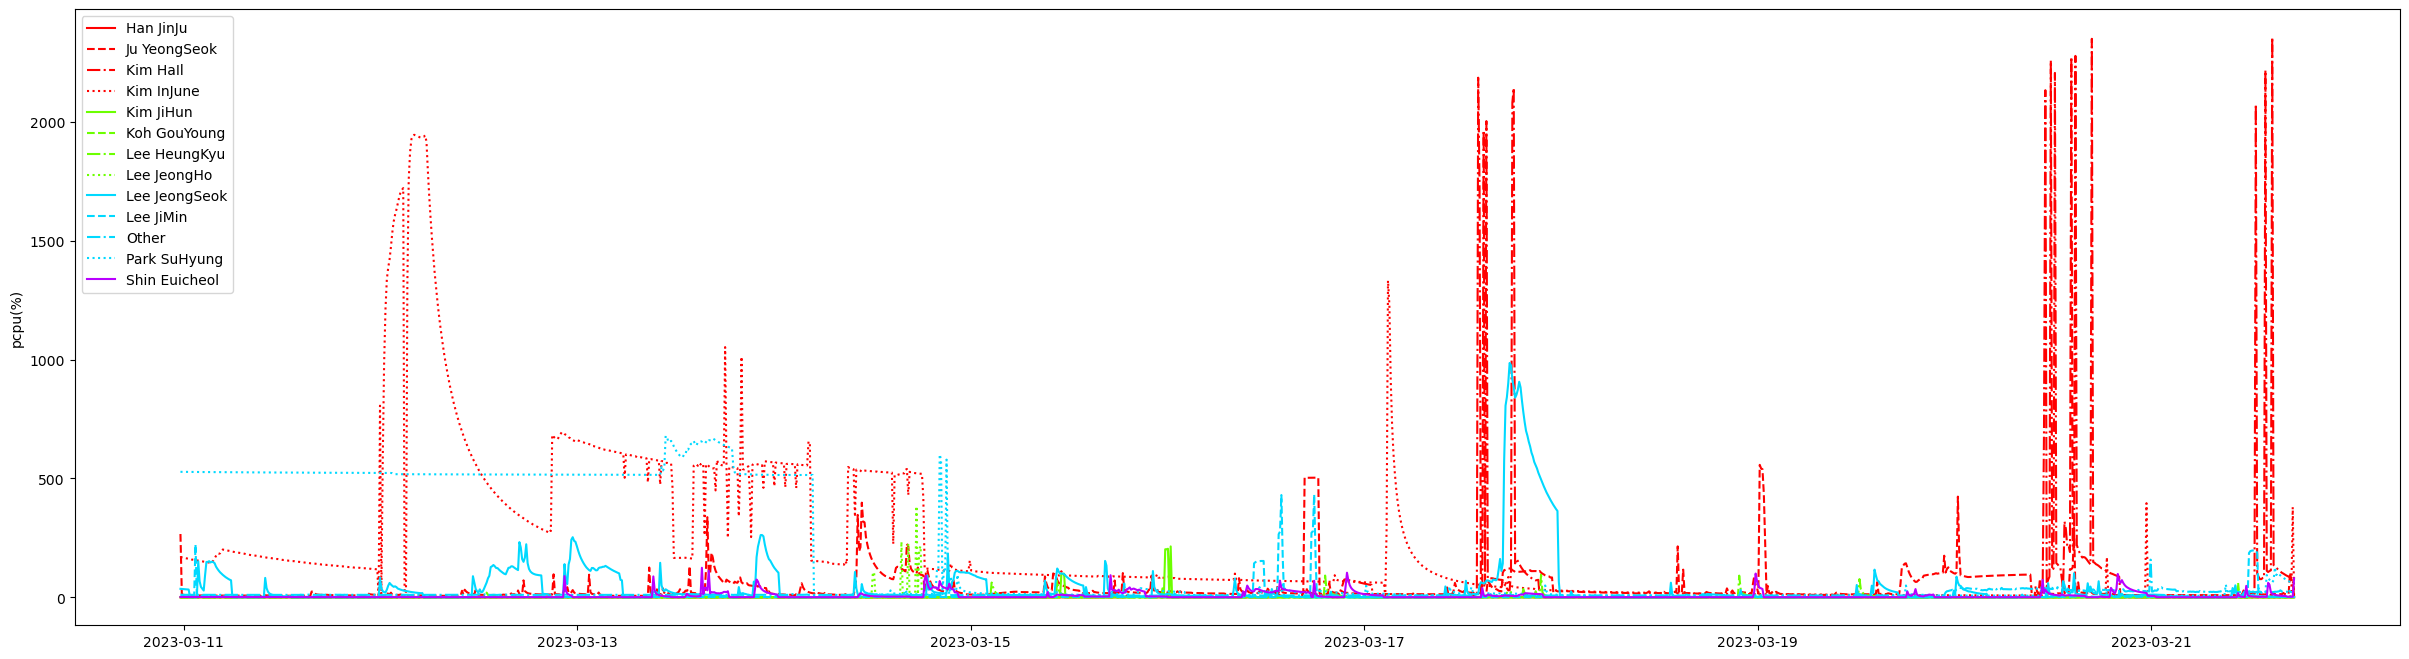

In [24]:
plot_one_node(dfs['bnode15'], mode='pcpu', membertype='lab')

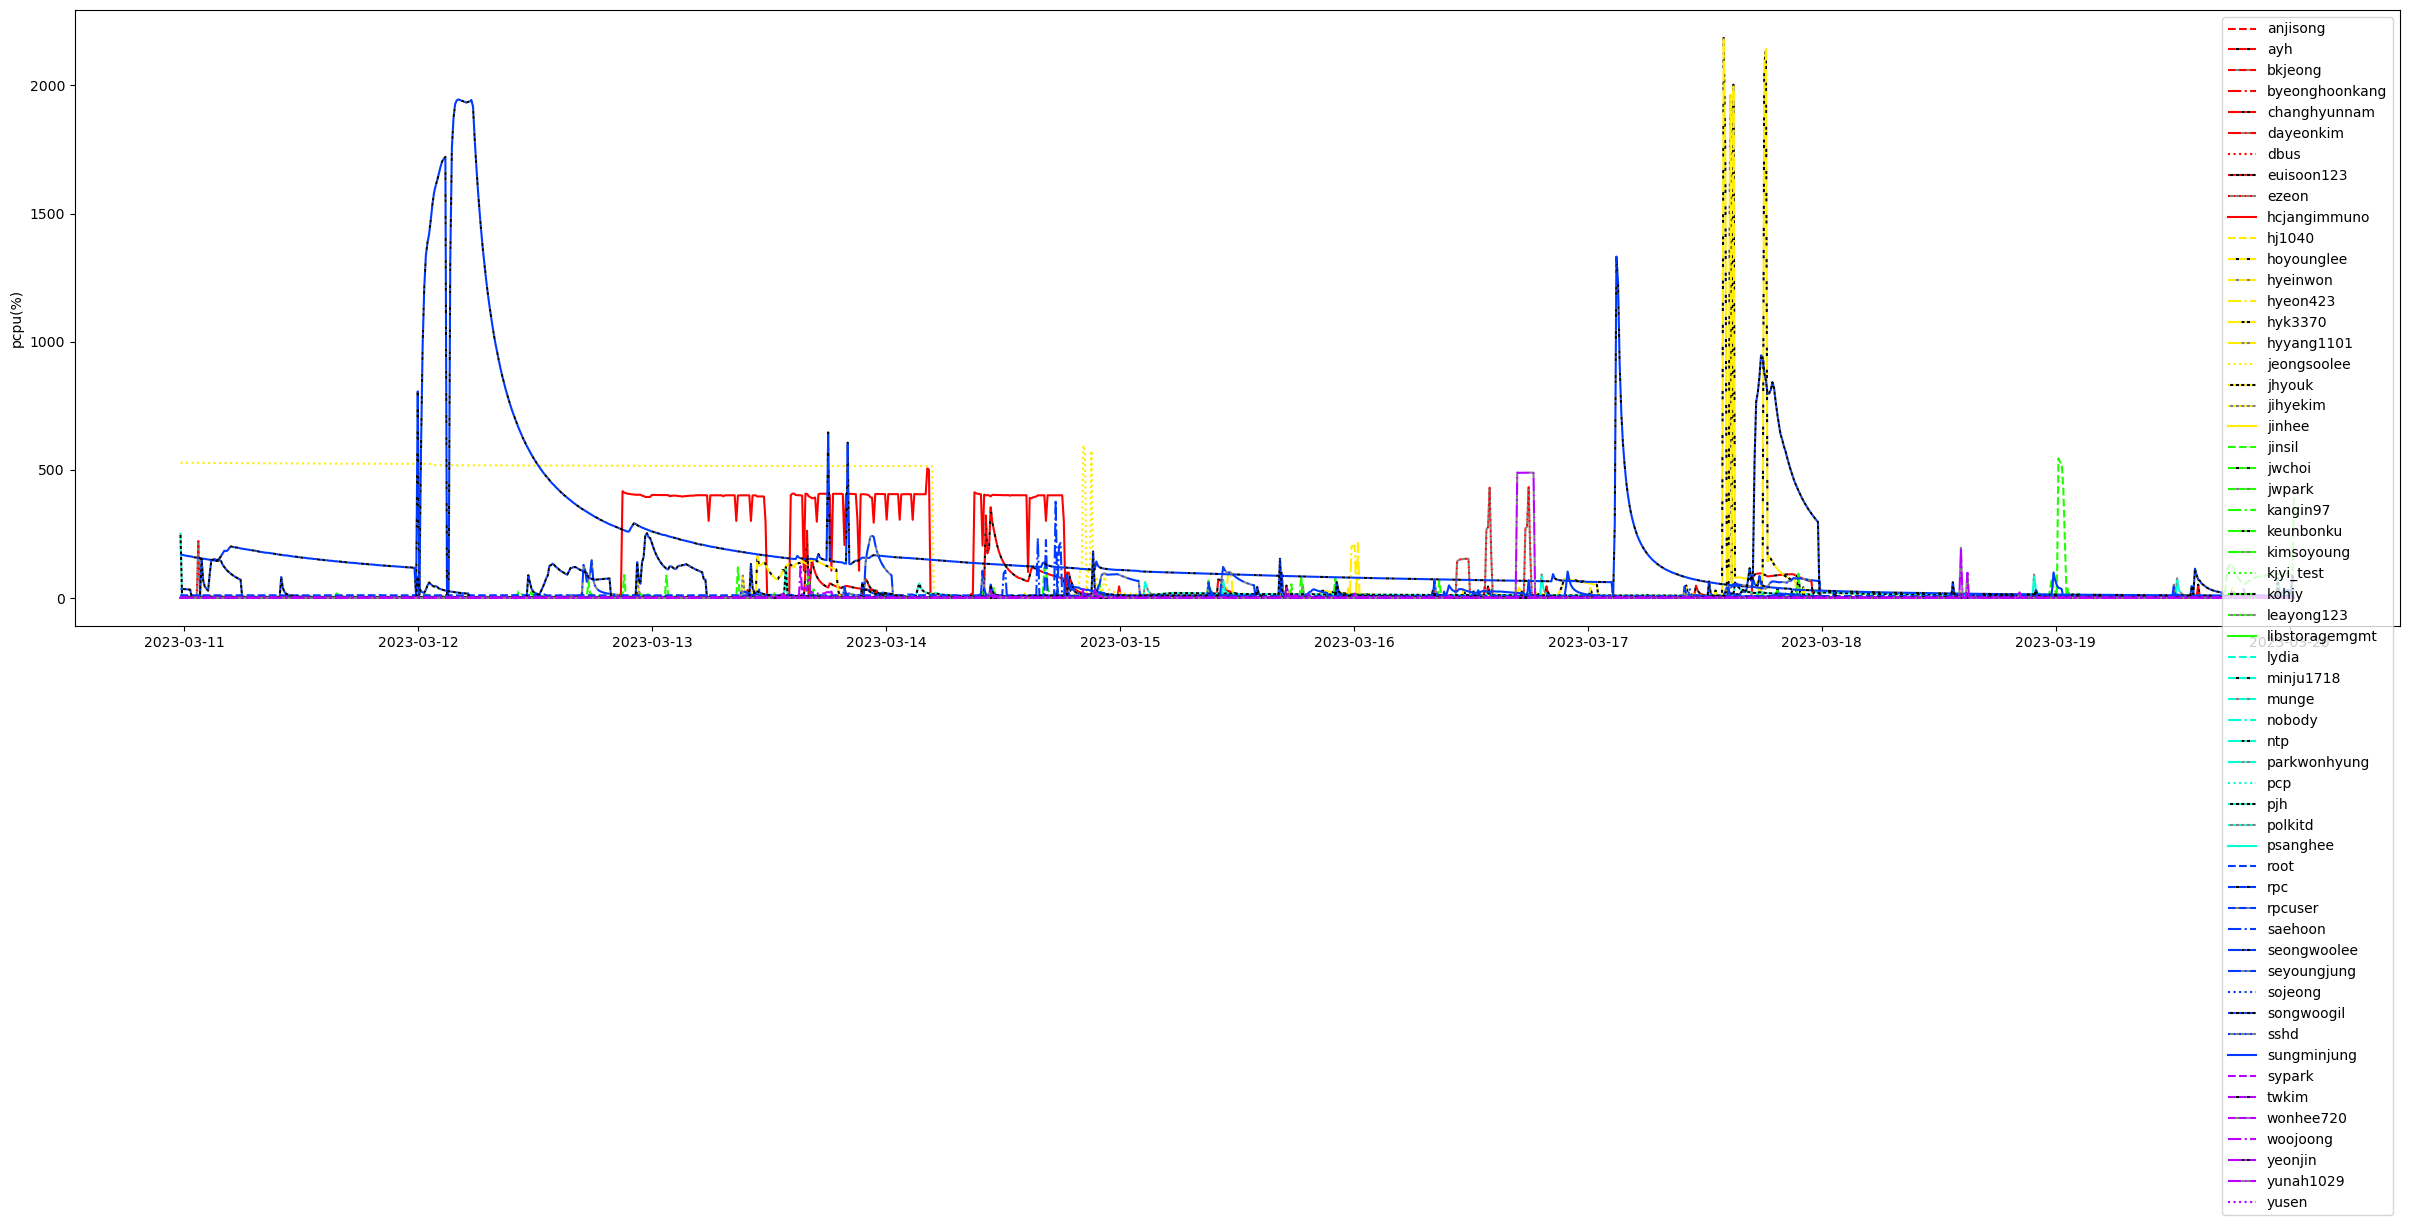

In [17]:
plot_one_node(dfs['bnode15'], mode='pcpu', membertype='user')

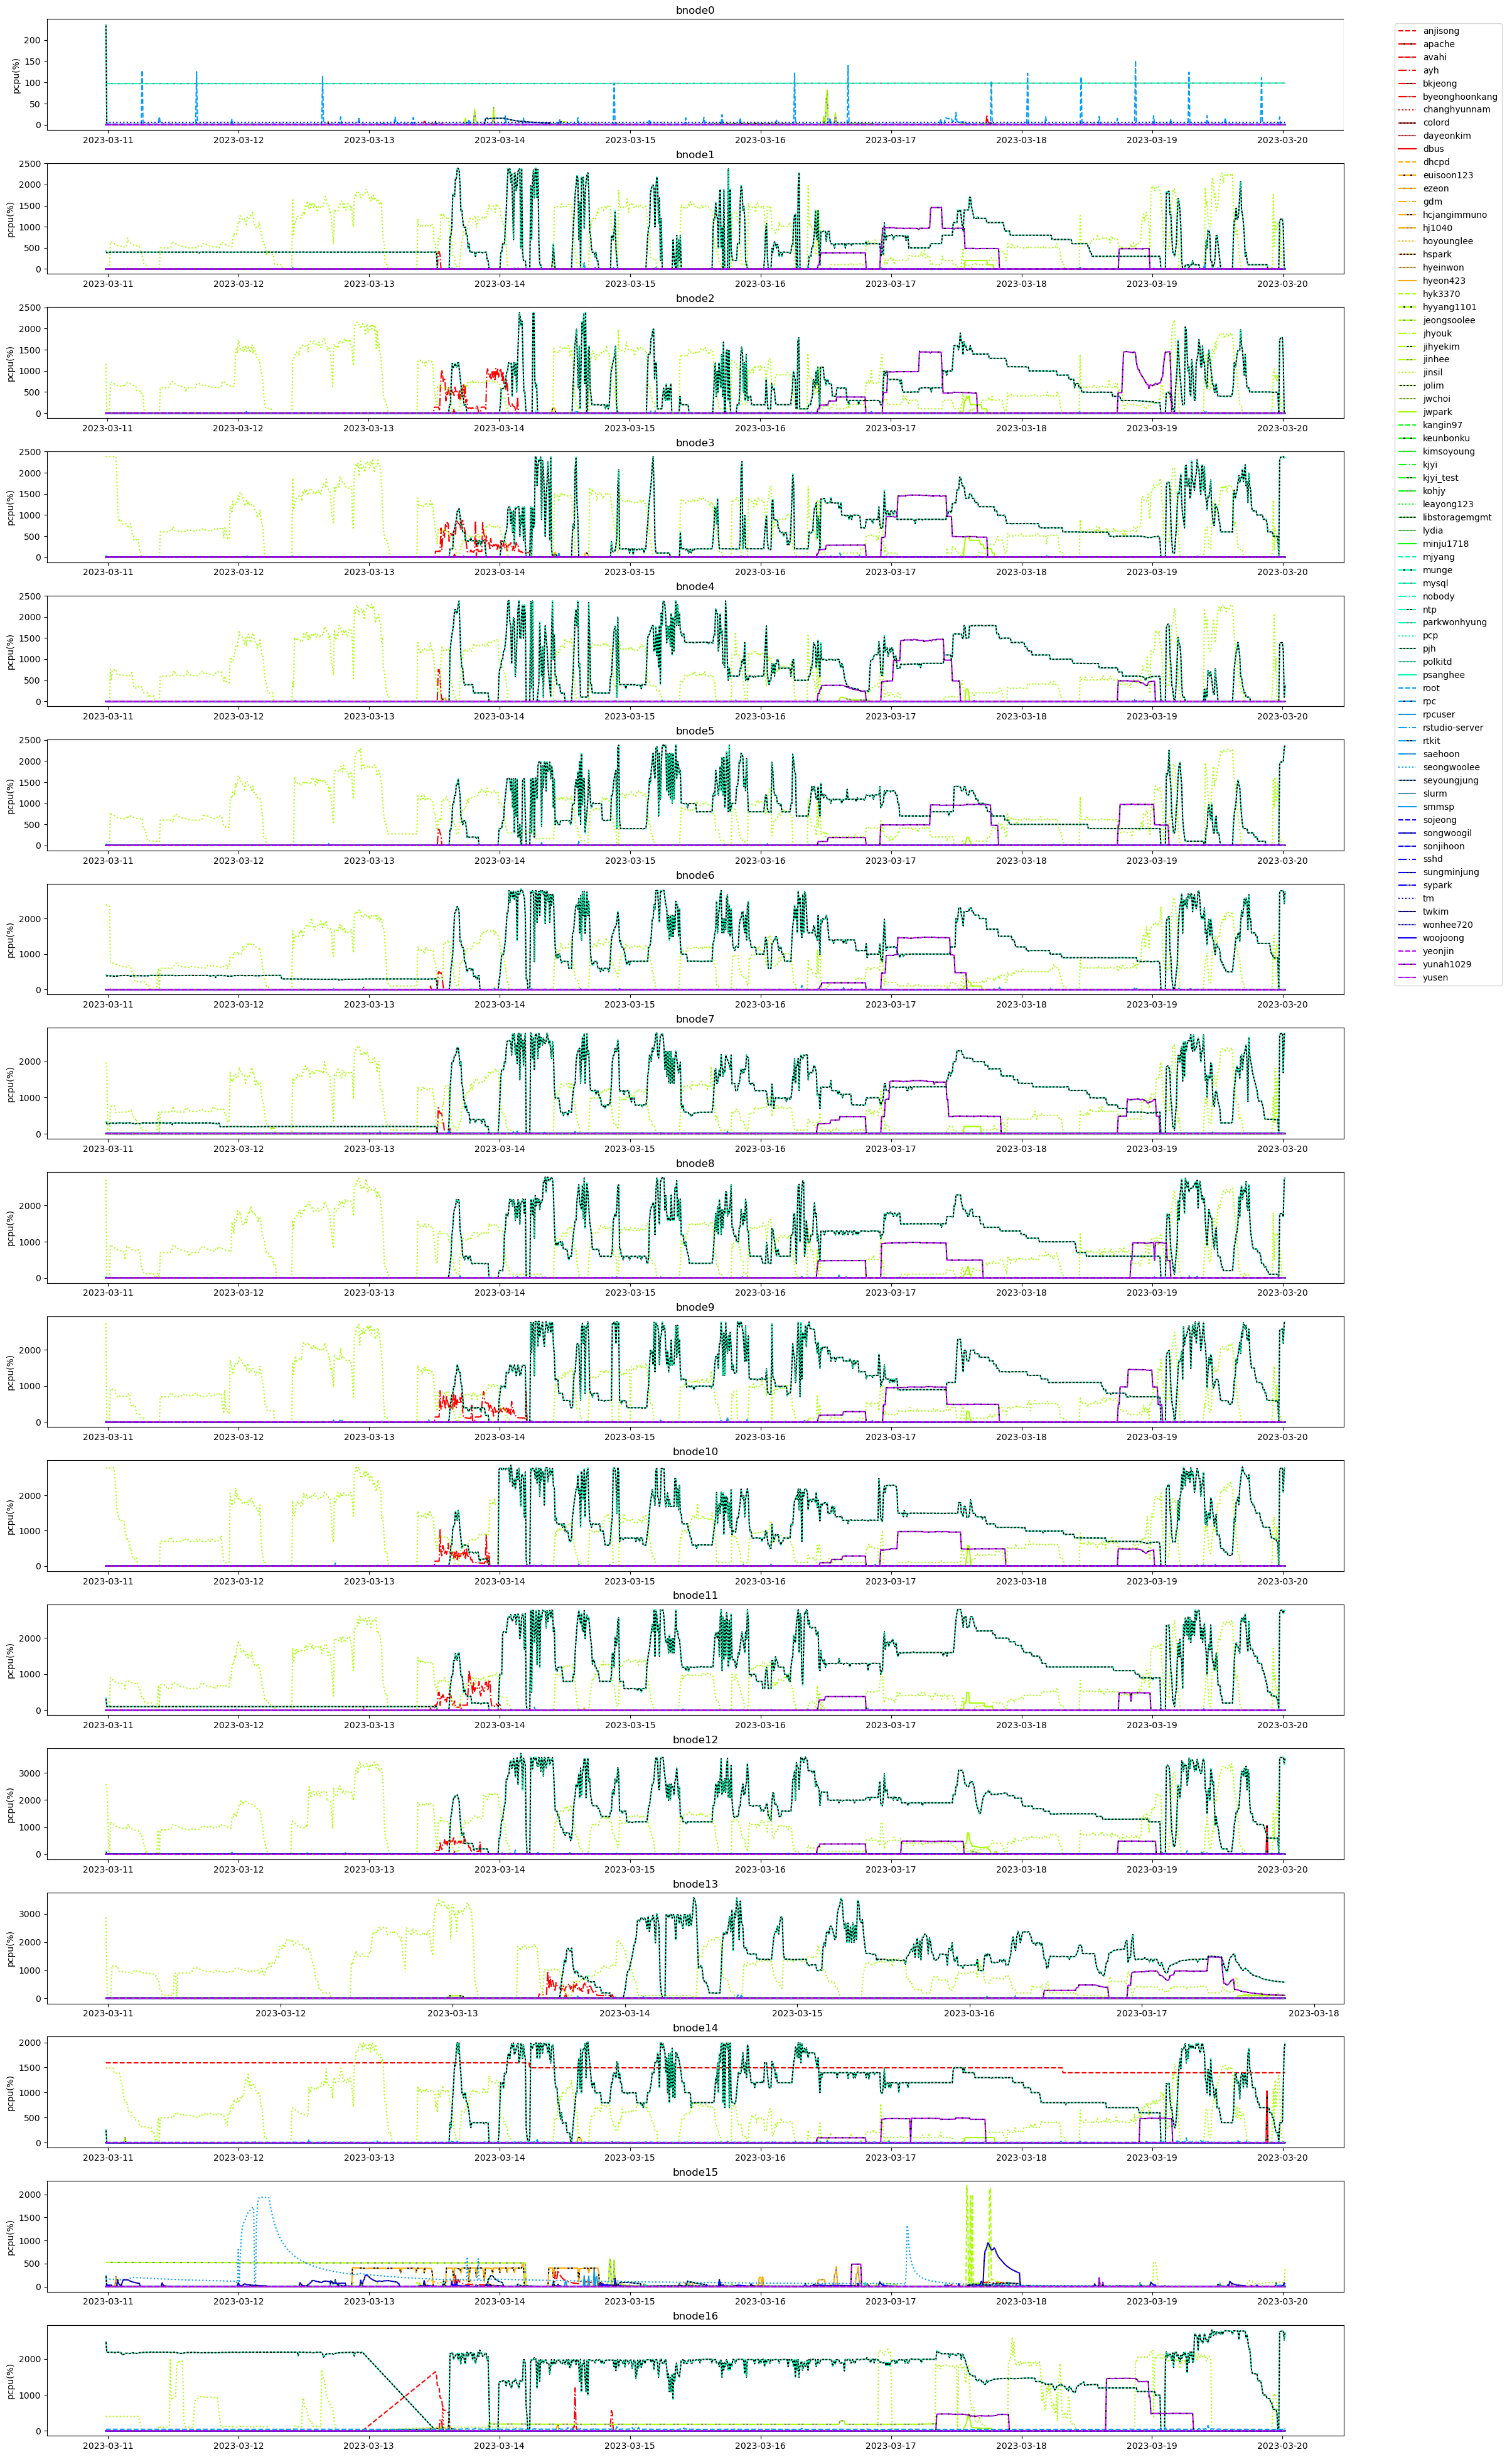

In [19]:
plot_all_nodes(dfs, mode='pcpu', membertype='user', figsize=(30, 50))